In [63]:
%load_ext autoreload
%autoreload 2

In [156]:
# numeric imports
import torch
import numpy as np
# gp imports
import gpytorch
from src.models.sparse.gridded_kronecker_structure import GriddedMatern12ExactGP, GriddedMatern12SVGP, GriddedMatern12ASVGP, GriddedMatern12VFFGP, Matern12GriddedGP
# plottin gimports
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# utils imports
from src.utils.dataloaders import MissionData
# misc imports
from tqdm import tqdm


# Data

In [2]:
# arguments
my_root_folder = '/Users/maxnorman/UCL/dissertation/data/raw'
my_mission_name = 'al'
my_years = ['2013']
my_months = ['04']
my_latitude_range = (51, 61)
my_longitude_range = (-3, 10)

# create mission data object
al_2013_03 = MissionData(
                        root_folder = my_root_folder, 
                        mission_name = my_mission_name, 
                        years = my_years, 
                        months = my_months,
                        latitude_range = my_latitude_range,
                        longitude_range = my_longitude_range
                        )

# extract data
al_2013_03_long = al_2013_03.mission_data.longitude.values
al_2013_03_lat = al_2013_03.mission_data.latitude.values
al_2013_03_sla = al_2013_03.mission_data.sla_filtered.values


Loading data for mission: 'al'
> 2013-04 | completed


In [4]:
# Training Data
X_train = torch.tensor(np.c_[al_2013_03_long, al_2013_03_lat], dtype = torch.float64)
y_train = torch.tensor(al_2013_03_sla, dtype = torch.float64)

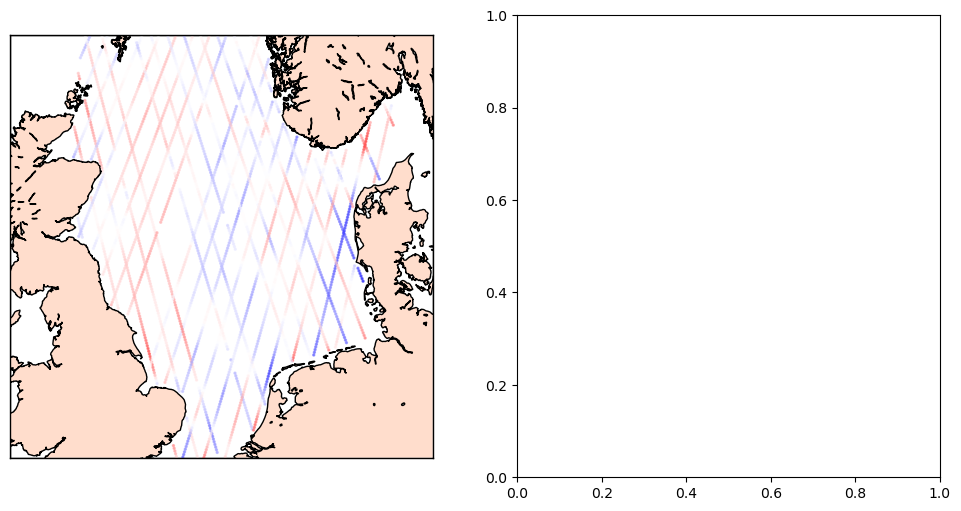

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
m = Basemap(projection='gnom', resolution='h', width=1.E6, height=1.E6, lat_0=56, lon_0=3, ax=ax1)
m.drawcoastlines()
m.drawmapboundary(fill_color="#FFFFFF")

# map (long, lat) to (x, y) for plotting
x, y = m(X_train[:,0], X_train[:,1])  # Convert coordinates to Basemap projection
m.scatter(x, y, c=y_train, cmap='seismic', alpha=0.5, s = 2, vmin=-0.5, vmax=0.5)

m.fillcontinents(color="#FFDDCC", ); #lake_color='#DDEEFF'

In [6]:
# get grid limits
print(f'Grid limits dim 1:  x1 min {X_train[:, 0].min().item()}, x1 max {X_train[:, 0].max().item()}')
print(f'Grid limits dim 2:  x2 min {X_train[:, 1].min().item()}, x2 max {X_train[:, 1].max().item()}')

Grid limits dim 1:  x1 min -2.994540000000029, x1 max 9.976116
Grid limits dim 2:  x2 min 51.003121, x2 max 60.999793999999994


In [7]:
# min max scaling
X_train[:, 0] = (X_train[:, 0] - X_train[:, 0].min()) / (X_train[:, 0].max() - X_train[:, 0].min())
X_train[:, 1] = (X_train[:, 1] - X_train[:, 1].min()) / (X_train[:, 1].max() - X_train[:, 1].min())

# Model Parameters

In [25]:
N_B0_SPLINES = 20
DIM1_GRID_LIMS = (0, 1)
DIM2_GRID_LIMS = (0, 1)

# Exact GP

In [26]:
exactgp = GriddedMatern12ExactGP(
                        train_x = X_train[::5], train_y = y_train[::5],   
                        n_b0_splines = N_B0_SPLINES,
                        dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS,).to(torch.float64)

In [27]:
# fit the Exact GP
EXACT_GP_LR = 0.1
EXACT_GP_ITERATIONS = 100
# set model and likelihood into training mode
exactgp.train()
exactgp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exactgp.parameters(), lr = EXACT_GP_LR)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exactgp.likelihood, exactgp)
history = torch.zeros(EXACT_GP_ITERATIONS)
for i in tqdm(range(EXACT_GP_ITERATIONS)):
    optimizer.zero_grad()
    output = exactgp(exactgp.train_x)
    loss = -mll(output, exactgp.train_y)
    history[i] = loss.item()
    loss.backward()
    optimizer.step()

# print('='*((5*15) + 4))
# print(f"{'Iteration':^15}|{'Loss':^15}|{'Noise':^15}|{'Lengthscale':^15}|{'Outputscale':^15}")
# print('='*((5*15) + 4))
# print(f"{i+1:^15}|{loss.item():^15.3f}|{exactgp.likelihood.noise.item():^15.3f}|{exactgp.kernel.base_kernel.lengthscale.item():^15.3f}|{exactgp.kernel.outputscale.item():^15.3f}")

100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


# SVGP

In [157]:
# inducing points
N_INDUCING = 100
Z = torch.tensor(np.random.rand(N_INDUCING, 2), dtype=torch.float64)

In [158]:
gridded_svgp = GriddedMatern12SVGP(
                    X_train.to(torch.float64), y_train.to(torch.float64), Z.to(torch.float64), # data part
                    n_b0_splines=N_B0_SPLINES, # vff part
                    dim1_grid_lims=DIM1_GRID_LIMS, dim2_grid_lims=DIM2_GRID_LIMS).to(torch.float64) # spline part

In [165]:
# # fit the VFFGP
# LR = 0.1
# ITERATIONS = 100
# optimizer = torch.optim.Adam(gridded_svgp.parameters(), lr=LR)
# # perform gradient descent
# svgp_history = torch.empty(ITERATIONS)
# for i in tqdm(range(ITERATIONS)):
#     optimizer.zero_grad()
#     elbow = -gridded_svgp._elbo()
#     svgp_history[i] = elbow.item()
#     elbow.backward()
#     optimizer.step()
# ;

In [35]:
# plt.plot(svgp_history)

# VFFGP

In [252]:
gridded_vffgp = GriddedMatern12VFFGP(
                    X_train, y_train, # data part
                    nfrequencies=10, vffdim1lims=(0., 2.), vffdim2lims=(0., 2.), # vff part
                    nsplines = N_B0_SPLINES, griddim1lims=DIM1_GRID_LIMS, griddim2lims=DIM2_GRID_LIMS).to(torch.float64) # spline part

In [179]:
# fit the VFFGP
# LR = 0.1
# ITERATIONS = 10
# optimizer = torch.optim.Adam(gridded_svgp.parameters(), lr=LR)
# # perform gradient descent
# svgp_history = torch.empty(ITERATIONS)
# for i in tqdm(range(ITERATIONS)):
#     optimizer.zero_grad()
#     elbow = -gridded_svgp._elbo()
#     svgp_history[i] = elbow.item()
#     elbow.backward()
#     optimizer.step()
;

''

# ASVGP

In [216]:
from src.models.sparse.gridded_kronecker_structure import GriddedMatern12ASVGP

In [255]:
N_B0SPLINES = 20
PADDING_FACTOR = 1
gridded_asvgp = GriddedMatern12ASVGP(X_train, y_train, N_B0SPLINES, PADDING_FACTOR, (0,1), (0,1))

In [256]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 10
optimizer = torch.optim.Adam(gridded_asvgp.parameters(), lr=LR)
# perform gradient descent
gridded_asvgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -gridded_asvgp._elbo()
    gridded_asvgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


''

# GriddedGP (Mine)

In [222]:
griddedgp = Matern12GriddedGP(X_train, y_train, N_B0_SPLINES + 1, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64)

In [223]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 10
optimizer = torch.optim.Adam(griddedgp.parameters(), lr=LR)
# perform gradient descent
griddedgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -griddedgp._elbo()
    griddedgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

  0%|          | 0/10 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


''

# Model Comparison

In [257]:
# get the q(v)s
exactgp_grid_pred = exactgp.q_v()
svgp_grid_pred = gridded_svgp.q_v()
vffgp_grid_pred = gridded_vffgp.q_v()
asvgp_grid_pred = gridded_asvgp.q_v()
griddedgp_grid_pred = griddedgp.q_v()

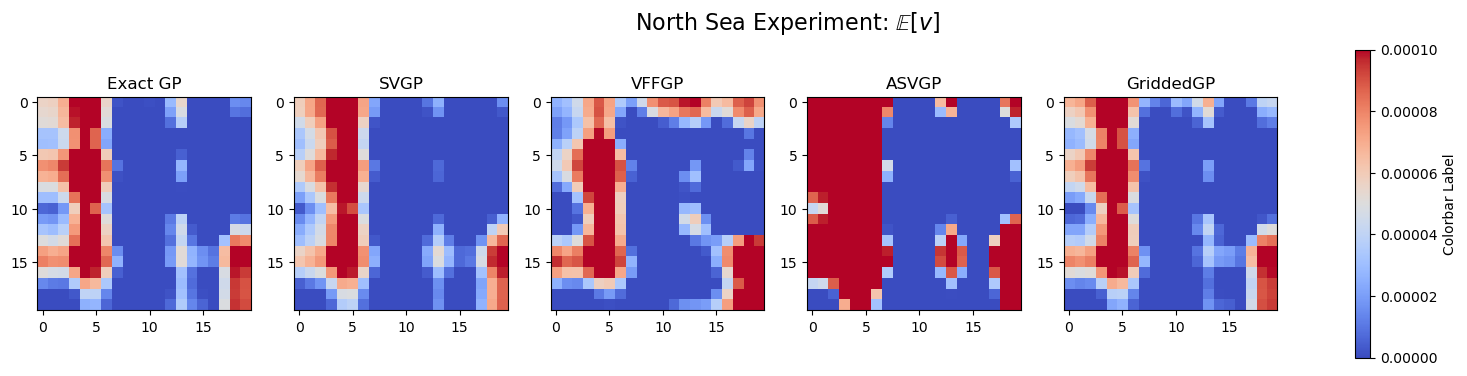

In [260]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

# exact GP
ax1.set_title('Exact GP')
im1 = ax1.imshow(exactgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin=0, vmax=0.0001)

# SVGP
ax2.set_title('SVGP')
im2 = ax2.imshow(svgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin=0, vmax=0.0001)

# VFFGP
ax3.set_title('VFFGP')
im3 = ax3.imshow(vffgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin=0, vmax=0.0001)

# ASVGP
ax4.set_title('ASVGP')
im4 = ax4.imshow(asvgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin=0, vmax=0.0001)

# GriddedGP
ax5.set_title('GriddedGP')
im5 = ax5.imshow(griddedgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin=0, vmax=0.0001)

plt.suptitle(r'North Sea Experiment: $\mathbb{E}[v]$', fontsize=16)
cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3, ax4, ax5])
cbar.set_label('Colorbar Label')

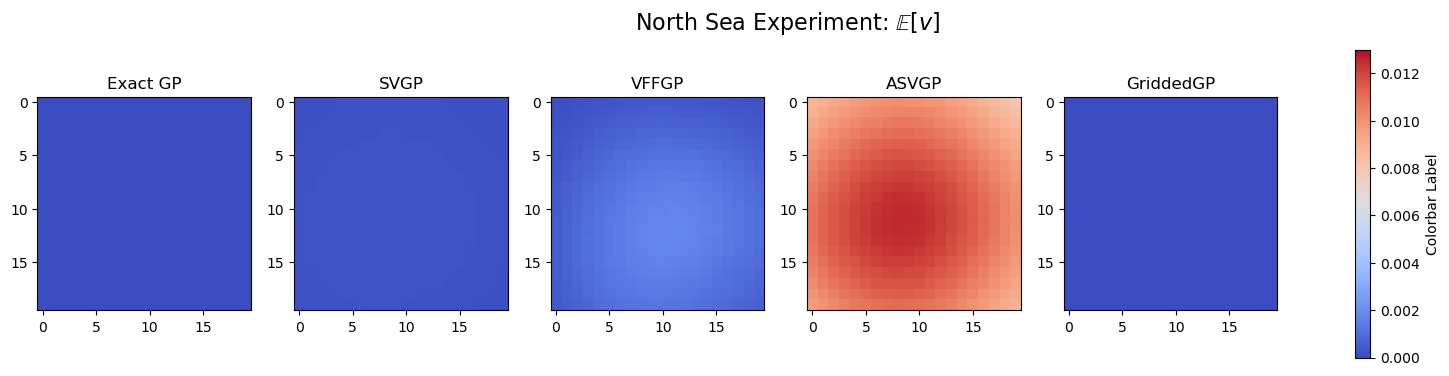

In [280]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

# exact GP
ax1.set_title('Exact GP')
im1 = ax1.imshow(torch.diagonal(exactgp_grid_pred.covariance_matrix).detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin = 0, vmax = 0.013)

# SVGP
ax2.set_title('SVGP')
im2 = ax2.imshow(torch.diagonal(svgp_grid_pred.covariance_matrix).detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin = 0, vmax = 0.013)

# VFFGP
ax3.set_title('VFFGP')
im3 = ax3.imshow(torch.diagonal(vffgp_grid_pred.covariance_matrix).detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin = 0, vmax = 0.013)

# ASVGP
ax4.set_title('ASVGP')
im4 = ax4.imshow(torch.diagonal(asvgp_grid_pred.covariance_matrix).detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin = 0, vmax = 0.013)

# GriddedGP
ax5.set_title('GriddedGP')
im5 = ax5.imshow(torch.diagonal(griddedgp_grid_pred.covariance_matrix).detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T, cmap='coolwarm', origin='upper', vmin = 0, vmax = 0.013)

plt.suptitle(r'North Sea Experiment: $\mathbb{E}[v]$', fontsize=16)
cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3, ax4, ax5])
cbar.set_label('Colorbar Label')

In [279]:
torch.diagonal(exactgp_grid_pred.covariance_matrix).detach().numpy().min()

1.5272732578669987e-05